In [1]:
import fermat as F
import numpy as np
import scipy.sparse as sp
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

importe todo y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [2]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        
        res+=dist                      
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient


#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    assert(len(initialData.flatten())==len(x))
    dimension=initialData.shape[1]
    real_x=x.reshape(-1,dimension)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dimension*i:(i+1)*dimension]=local_gradient
    return res,gradient


In [3]:
data=np.random.random((10,2))

x=np.ones(16)

##Euclidean
print(euclidean_cost(x,data[0:8,:]))

##Fermat

initialData=data[0:8,:]
dimension=2
alpha=2
k=2
f_dist,tree=fermat_graph(data,alpha=alpha)


fermat_cost(x,initialData,dimension,f_dist,tree,data,k,alpha)

(5.0129010741481, array([1.35058145, 0.43955184, 0.56771957, 0.51857352, 0.62649954,
       0.16850105, 1.30218125, 1.22512701, 1.17769351, 1.88874185,
       0.56137874, 0.45509046, 0.69852144, 1.75007139, 1.09476999,
       1.89732263]))


(2.3256213929616187,
 array([0.62649954, 0.16850105, 0.56137874, 0.45509046, 0.62649954,
        0.16850105, 0.62649954, 0.16850105, 0.62649954, 0.16850105,
        0.56137874, 0.45509046, 0.56137874, 0.45509046, 0.62649954,
        0.16850105]))

Armo aca los datos que podrian servir para al menos probar que ande

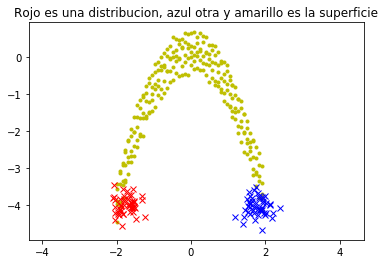

In [4]:
puntos=50

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)


dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)




y1, y2 = np.random.multivariate_normal([1.7,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1.7,-4], [[0.05,0],[0,0.05]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'x',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

# ACA ARRANCA LO NUEVO

## Tomo la dist de fermat al cuadrado por lo que dijo esteban, sino cualquier solucion en la geodesica va a ser lo mismo

In [5]:
data=np.concatenate((Zcol,Ycol,W),axis=0)

alpha=2
k=10
dimension=2
h=1 #TUNEARLO E INVESTIGAR (es el bandwith de los kernel)

f_dist,tree=fermat_graph(data,alpha=alpha)
f_dist=f_dist**2

x=np.concatenate((Zcol,Ycol),axis=0) #los datos X iniciales, las distribuciones. 
z=np.matrix([0 for i in range(Zcol.shape[0])]+[1 for i in range(Ycol.shape[0])]).T
#le pongo label 0 a la primera y 1 a la segunda

### Defino las funciones que utilizan en el paper de tabak. Basicamente los nucleos y sus gradientes (armo una matriz que tiene el resultado de los kernel con todos los posibles centros evaluados en todo los posibles puntos), esta matriz C que definen, el lagrangiano y su gradiente 

In [6]:
def kernel(x,centro,h,dimension):
    return np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 
     
def kernel_grad(x,centro,h,dimension):
    return -(1/h**2)*(x-centro)*np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 
     
    
    
#vector con todos los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,1)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C

def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C

#matriz que tieneen el lugar ij al kernel(y_i,y_j) y lo mismo con gradiente (en la primer coord el gradiente)
def kernel_matrix_y(y,h,dimension):
        y_matrix=np.zeros((y.shape[0],y.shape[0]))
        grad_matrix=np.zeros((y.shape[0],y.shape[0],dimension))
        for i in range(y.shape[0]):
            for j in range(y.shape[0]):
                y_matrix[i,j]=kernel(y[i,:],y[j,:],h,dimension)
                grad_matrix[i,j,:]=kernel_grad(y[i,:],y[j,:],h,dimension)
        return y_matrix,grad_matrix
                
                
def lagrangiano(y,x,landa,h,kernel_matrix,C): 
        dimension=y.shape[1]
        cost=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)[0]
        #cost=euclidean_cost(y.flatten(),x)[0]
        return  cost+ landa * (kernel_matrix.flatten() @ C.flatten().T)
    #EN DISTINTOS LUGARES DICE DISTINTO LO QUE ES LE LAGRANGIANO (sobre que variable derivas en kernel)
    #YO ME CONVENCI QUE DEBERIA SER sum_i[ cost(x_i,y_i)+ sum_k[landa*kernel(y_i,y_k)*C_il]   ]

def lagrangiano_grad(y,x,landa,h,grad_matrix,C):
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
        
    cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)[1]
    #cost_grad=euclidean_cost(y.flatten(),x)[1]
    return cost_grad+landa*aux

### El algoritmo que proponen (falta poner bien la formula del landamin que no la hice aun, ver que seria un buen beta y un buen landamax -ademas de una learningrate inicial y un h (el bandwith) inicial-)

In [7]:
#x va a ser los puntos iniciales (distintas distribuciones)
#y van a ser los transportados (baricentro)



#COMO ELIJO LANDA0, LEARNINGRATE0, LANDAMAX,BETA ?
y=x
kernel_matrix,grad_matrix=kernel_matrix_y(y,h,dimension)
niter=100
learningrate0=1000
beta=0.01  #es el alpha que pone tabak
landamax=1000 #TODO
landa0=0.001 #TODO



C=armar_C_categorico(z) #EN Z PONGO FILA A FILA LOS DISTINTOS VALORES DE Z
landa=landa0
learningrate=learningrate0
n=0

while (n<niter):
    learningrate=min(learningrate*2.01,learningrate0)
    
    landamin=landa*2#beta-1#TODO la cuentaza
    
    
    if(landamin>landa and landamin<landamax): 
        landa=landamin
    elif(landamin>landamax): 
        landa=landamax
    
    yviejo=y
    gradienteLagrangiano=lagrangiano_grad(y,x,landa,h,grad_matrix,C)
    print(np.linalg.norm(gradienteLagrangiano))
    
    while(True):
        y=(y.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)
        kernel_matrix,grad_matrix=kernel_matrix_y(y,h,dimension)
        if(lagrangiano(y,x,landa,h,kernel_matrix,C)<=lagrangiano(yviejo,x,landa,h,kernel_matrix,C)): 
            break
        learningrate=learningrate/2 
        print("aca en el while... El learningrate:" + str(learningrate))
    print("iteracion: "+str(n))
    n=n+1
        

0.00042449648117218967
aca en el while... El learningrate:500.0
aca en el while... El learningrate:250.0
aca en el while... El learningrate:125.0
aca en el while... El learningrate:62.5
aca en el while... El learningrate:31.25
aca en el while... El learningrate:15.625
aca en el while... El learningrate:7.8125
aca en el while... El learningrate:3.90625
aca en el while... El learningrate:1.953125
aca en el while... El learningrate:0.9765625
aca en el while... El learningrate:0.48828125
aca en el while... El learningrate:0.244140625
aca en el while... El learningrate:0.1220703125
aca en el while... El learningrate:0.06103515625
aca en el while... El learningrate:0.030517578125
aca en el while... El learningrate:0.0152587890625
aca en el while... El learningrate:0.00762939453125
aca en el while... El learningrate:0.003814697265625
aca en el while... El learningrate:0.0019073486328125
aca en el while... El learningrate:0.00095367431640625
aca en el while... El learningrate:0.000476837158203

aca en el while... El learningrate:5.605193857299268e-42
aca en el while... El learningrate:2.802596928649634e-42
aca en el while... El learningrate:1.401298464324817e-42
aca en el while... El learningrate:7.006492321624085e-43
aca en el while... El learningrate:3.5032461608120427e-43
aca en el while... El learningrate:1.7516230804060213e-43
aca en el while... El learningrate:8.758115402030107e-44
aca en el while... El learningrate:4.3790577010150533e-44
aca en el while... El learningrate:2.1895288505075267e-44
aca en el while... El learningrate:1.0947644252537633e-44
aca en el while... El learningrate:5.4738221262688167e-45
aca en el while... El learningrate:2.7369110631344083e-45
aca en el while... El learningrate:1.3684555315672042e-45
aca en el while... El learningrate:6.842277657836021e-46
aca en el while... El learningrate:3.4211388289180104e-46
aca en el while... El learningrate:1.7105694144590052e-46
aca en el while... El learningrate:8.552847072295026e-47
aca en el while... El

aca en el while... El learningrate:5.026911708464872e-85
aca en el while... El learningrate:2.513455854232436e-85
aca en el while... El learningrate:1.256727927116218e-85
aca en el while... El learningrate:6.28363963558109e-86
aca en el while... El learningrate:3.141819817790545e-86
aca en el while... El learningrate:1.5709099088952725e-86
aca en el while... El learningrate:7.8545495444763625e-87
aca en el while... El learningrate:3.9272747722381812e-87
aca en el while... El learningrate:1.9636373861190906e-87
aca en el while... El learningrate:9.818186930595453e-88
aca en el while... El learningrate:4.9090934652977266e-88
aca en el while... El learningrate:2.4545467326488633e-88
aca en el while... El learningrate:1.2272733663244316e-88
aca en el while... El learningrate:6.136366831622158e-89
aca en el while... El learningrate:3.068183415811079e-89
aca en el while... El learningrate:1.5340917079055395e-89
aca en el while... El learningrate:7.670458539527698e-90
aca en el while... El le

aca en el while... El learningrate:1.8033161362862765e-127
aca en el while... El learningrate:9.016580681431383e-128
aca en el while... El learningrate:4.5082903407156913e-128
aca en el while... El learningrate:2.2541451703578456e-128
aca en el while... El learningrate:1.1270725851789228e-128
aca en el while... El learningrate:5.635362925894614e-129
aca en el while... El learningrate:2.817681462947307e-129
aca en el while... El learningrate:1.4088407314736535e-129
aca en el while... El learningrate:7.044203657368268e-130
aca en el while... El learningrate:3.522101828684134e-130
aca en el while... El learningrate:1.761050914342067e-130
aca en el while... El learningrate:8.805254571710335e-131
aca en el while... El learningrate:4.4026272858551673e-131
aca en el while... El learningrate:2.2013136429275836e-131
aca en el while... El learningrate:1.1006568214637918e-131
aca en el while... El learningrate:5.503284107318959e-132
aca en el while... El learningrate:2.7516420536594796e-132
aca e

aca en el while... El learningrate:1.2938158758247024e-169
aca en el while... El learningrate:6.469079379123512e-170
aca en el while... El learningrate:3.234539689561756e-170
aca en el while... El learningrate:1.617269844780878e-170
aca en el while... El learningrate:8.08634922390439e-171
aca en el while... El learningrate:4.043174611952195e-171
aca en el while... El learningrate:2.0215873059760975e-171
aca en el while... El learningrate:1.0107936529880487e-171
aca en el while... El learningrate:5.0539682649402436e-172
aca en el while... El learningrate:2.5269841324701218e-172
aca en el while... El learningrate:1.2634920662350609e-172
aca en el while... El learningrate:6.3174603311753045e-173
aca en el while... El learningrate:3.1587301655876523e-173
aca en el while... El learningrate:1.5793650827938261e-173
aca en el while... El learningrate:7.896825413969131e-174
aca en el while... El learningrate:3.9484127069845653e-174
aca en el while... El learningrate:1.9742063534922827e-174
aca 

aca en el while... El learningrate:9.282673663550585e-212
aca en el while... El learningrate:4.6413368317752925e-212
aca en el while... El learningrate:2.3206684158876463e-212
aca en el while... El learningrate:1.1603342079438231e-212
aca en el while... El learningrate:5.801671039719116e-213
aca en el while... El learningrate:2.900835519859558e-213
aca en el while... El learningrate:1.450417759929779e-213
aca en el while... El learningrate:7.252088799648895e-214
aca en el while... El learningrate:3.6260443998244473e-214
aca en el while... El learningrate:1.8130221999122236e-214
aca en el while... El learningrate:9.065110999561118e-215
aca en el while... El learningrate:4.532555499780559e-215
aca en el while... El learningrate:2.2662777498902796e-215
aca en el while... El learningrate:1.1331388749451398e-215
aca en el while... El learningrate:5.665694374725699e-216
aca en el while... El learningrate:2.8328471873628494e-216
aca en el while... El learningrate:1.4164235936814247e-216
aca e

aca en el while... El learningrate:6.6599917309756716e-254
aca en el while... El learningrate:3.3299958654878358e-254
aca en el while... El learningrate:1.6649979327439179e-254
aca en el while... El learningrate:8.324989663719589e-255
aca en el while... El learningrate:4.1624948318597947e-255
aca en el while... El learningrate:2.0812474159298974e-255
aca en el while... El learningrate:1.0406237079649487e-255
aca en el while... El learningrate:5.2031185398247434e-256
aca en el while... El learningrate:2.6015592699123717e-256
aca en el while... El learningrate:1.3007796349561859e-256
aca en el while... El learningrate:6.503898174780929e-257
aca en el while... El learningrate:3.2519490873904646e-257
aca en el while... El learningrate:1.6259745436952323e-257
aca en el while... El learningrate:8.129872718476162e-258
aca en el while... El learningrate:4.064936359238081e-258
aca en el while... El learningrate:2.0324681796190404e-258
aca en el while... El learningrate:1.0162340898095202e-258
a

aca en el while... El learningrate:2.3891548633682403e-296
aca en el while... El learningrate:1.1945774316841202e-296
aca en el while... El learningrate:5.972887158420601e-297
aca en el while... El learningrate:2.9864435792103004e-297
aca en el while... El learningrate:1.4932217896051502e-297
aca en el while... El learningrate:7.466108948025751e-298
aca en el while... El learningrate:3.7330544740128755e-298
aca en el while... El learningrate:1.8665272370064378e-298
aca en el while... El learningrate:9.332636185032189e-299
aca en el while... El learningrate:4.6663180925160944e-299
aca en el while... El learningrate:2.3331590462580472e-299
aca en el while... El learningrate:1.1665795231290236e-299
aca en el while... El learningrate:5.832897615645118e-300
aca en el while... El learningrate:2.916448807822559e-300
aca en el while... El learningrate:1.4582244039112795e-300
aca en el while... El learningrate:7.2911220195563975e-301
aca en el while... El learningrate:3.6455610097781987e-301
ac

aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El lea

aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0
aca en el while... El learningrate:0.0


KeyboardInterrupt: 

In [ ]:

plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'x',c='r')
plt.plot(y1,y2,'x',c='b')
plt.plot(y[:,0],y[:,1],'.',c='v')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()